In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import torchvision.transforms as transforms
import imageio
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision.datasets import ImageFolder
from google.colab import drive
from torchvision.datasets import DatasetFolder
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils import model_zoo
from scipy.ndimage import zoom
from torchsummary import summary

In [ ]:
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
def get_base_config():
    """Base ViT config ViT"""
    return dict(
      dim=768,
      ff_dim=3072,
      num_heads=12,
      num_layers=12,
      attention_dropout_rate=0.0,
      dropout_rate=0.1,
      representation_size=768,
      classifier='token'
    )

def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = get_base_config()
    config.update(dict(patches=(16, 16)))
    return config

def get_b32_config():
    """Returns the ViT-B/32 configuration."""
    config = get_b16_config()
    config.update(dict(patches=(32, 32)))
    return config

def get_l16_config():
    """Returns the ViT-L/16 configuration."""
    config = get_base_config()
    config.update(dict(
        patches=(16, 16),
        dim=1024,
        ff_dim=4096,
        num_heads=16,
        num_layers=24,
        attention_dropout_rate=0.0,
        dropout_rate=0.1,
        representation_size=1024
    ))
    return config

def get_l32_config():
    """Returns the ViT-L/32 configuration."""
    config = get_l16_config()
    config.update(dict(patches=(32, 32)))
    return config

def drop_head_variant(config):
    config.update(dict(representation_size=None))
    return config


PRETRAINED_MODELS = {
    'B_16': {
      'config': get_b16_config(),
      'num_classes': 21843,
      'image_size': (224, 224),
      'url': "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16.pth"
    },
    'B_32': {
      'config': get_b32_config(),
      'num_classes': 21843,
      'image_size': (224, 224),
      'url': "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_32.pth"
    },
    'L_16': {
      'config': get_l16_config(),
      'num_classes': 21843,
      'image_size': (224, 224),
      'url': None
    },
    'L_32': {
      'config': get_l32_config(),
      'num_classes': 21843,
      'image_size': (224, 224),
      'url': "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/L_32.pth"
    },
    'B_16_imagenet1k': {
      'config': drop_head_variant(get_b16_config()),
      'num_classes': 1000,
      'image_size': (384, 384),
      'url': "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth"
    },
    'B_32_imagenet1k': {
      'config': drop_head_variant(get_b32_config()),
      'num_classes': 1000,
      'image_size': (384, 384),
      'url': "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_32_imagenet1k.pth"
    },
    'L_16_imagenet1k': {
      'config': drop_head_variant(get_l16_config()),
      'num_classes': 1000,
      'image_size': (384, 384),
      'url': "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/L_16_imagenet1k.pth"
    },
    'L_32_imagenet1k': {
      'config': drop_head_variant(get_l32_config()),
      'num_classes': 1000,
      'image_size': (384, 384),
      'url': "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/L_32_imagenet1k.pth"
    },
}

In [ ]:
class PositionalEmbedding1D(nn.Module):
  def __init__(self,seq_len,dim):
    super().__init__()
    self.pos_embedding = nn.Parameter(torch.zeros(1,seq_len,dim))

  def forward(self,x):
    return x + self.pos_embedding

In [ ]:
class MultiHeadedSelfAttention(nn.Module):
  def __init__(self,dim,num_heads, dropout=0):
    super().__init__()
    self.proj_q = nn.Linear(dim,dim)
    self.proj_k = nn.Linear(dim,dim)
    self.proj_v = nn.Linear(dim,dim)
    self.drop = nn.Dropout(dropout)
    self.n_heads = num_heads
    self.scores = None
  def forward(self,x,mask=None):
    q,k,v = self.proj_q(x),self.proj_k(x),self.proj_v(x)

    #(batch,num_patch,head,dim) -> (batch,head,num_patch,dim)
    q,k,v = (einops.rearrange(x,'b s (h w) -> b s h w',h = self.n_heads,w=x.shape[-1]//self.n_heads).transpose(1,2) for x in [q, k, v])
    #(batch,head,num_patch,num_patch)
    scores = torch.einsum('bhqd, bhkd -> bhqk',q,k) / np.sqrt(q.shape[-1])
    
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      scores.mask_fill(~mask,fill_value)

    scores = self.drop(F.softmax(scores,dim=-1))
    #(batch,head,num_patch,dim)
    out = torch.einsum('bhas, bhsv -> bhav',scores,v)
    #(batch,num_patch,emb_size)
    out = einops.rearrange(out, 'b h n d -> b n (h d)')
    
    self.scores = out
    return out

In [ ]:
class PositionWiseFeedForward(nn.Module):
  def __init__(self,dim,ff_dim):
    super().__init__()
    self.fc1 = nn.Linear(dim,ff_dim)
    self.fc2 = nn.Linear(ff_dim,dim)

  def forward(self,x):
    return self.fc2(F.gelu(self.fc1(x)))

In [ ]:
class Block(nn.Module):
  def __init__(self,dim,num_heads,ff_dim,dropout=0):
    super().__init__()
    self.attn = MultiHeadedSelfAttention(dim,num_heads,dropout)
    self.proj = nn.Linear(dim,dim)
    self.norm1 = nn.LayerNorm(dim,eps=1e-6)
    self.pwff = PositionWiseFeedForward(dim,ff_dim)
    self.norm2 = nn.LayerNorm(dim,eps=1e-6)
    self.drop = nn.Dropout(dropout)

  def forward(self,x,mask=None):
    h = self.drop(self.proj(self.attn(self.norm1(x),mask)))
    x = x + h
    h = self.drop(self.pwff(self.norm2(x)))
    x = x + h

    return x

In [ ]:
class Transformer(nn.Module):
  def __init__(self,num_layers, dim, num_heads,ff_dim,dropout=0):
    super().__init__()
    self.blocks = nn.ModuleList([
                                  Block(dim,num_heads,ff_dim,dropout) for _ in range(num_layers)
    ])

  def forward(self,x,mask=None):
    for block in self.blocks:
      x = block(x,mask)
    return x

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               name=None,
               pretrained=False,
               patches=16,
               dim=786,
               ff_dim=3072,
               num_heads=12,
               num_layers=12,
               attention_dropout_rate = 0.0,
               dropout_rate = 0.1,
               image_size = 224,
               num_classes = 1000,
               in_channels = 3):
    super().__init__()
    if name is not None:
      config = PRETRAINED_MODELS[name]['config']
      patches = config['patches'][0]
      dim = config['dim']
      ff_dim = config['ff_dim']
      num_heads = config['num_heads']
      num_layers = config['num_layers']
      attention_dropout_rate = config['attention_dropout_rate']
      dropout_rate = config['dropout_rate']
    
    p = image_size // patches
    num_patches = p * p

    self.patch_embedding = nn.Conv2d(in_channels,dim,kernel_size=patches,stride=patches)
    self.class_token = nn.Parameter(torch.zeros(1,1,dim))
    num_patches += 1

    self.positional_embedding = PositionalEmbedding1D(num_patches,dim)
    self.transformer = Transformer(num_layers,dim,num_heads,ff_dim,dropout_rate)
    self.norm = nn.LayerNorm(dim,eps=1e-6)
    self.fc = nn.Linear(dim,num_classes)

    self.init_weights()
    if pretrained:
      pretrained_in_channels = 3
      pretrained_image_size = PRETRAINED_MODELS[name]['image_size']
      pretrained_num_classes = PRETRAINED_MODELS[name]['num_classes']

      state_dict = model_zoo.load_url(PRETRAINED_MODELS[name]['url'])

      expected_missing_keys = []
      if pretrained_in_channels != in_channels and 'patch_embedding.weight' in state_dict:
        expected_missing_keys += ['patch_embedding.weight', 'patch_embedding.bias']
      if num_classes != pretrained_num_classes and 'fc.weight' in state_dict:
        expected_missing_keys += ['fc.weight', 'fc.bias']
      for key in expected_missing_keys:
        state_dict.pop(key)
      if pretrained_image_size != image_size:
        posemb = state_dict['positional_embedding.pos_embedding']
        posemb_tok,posemb_grid = posemb[:,:1],posemb[0,1:]
        old_grid_size = int(np.sqrt(len(posemb_grid)))
        new_grid_size = int(np.sqrt(num_patches-1))
        posemb_grid = posemb_grid.reshape(old_grid_size,old_grid_size,-1)
        zoom_factor = (new_grid_size/old_grid_size, new_grid_size/old_grid_size,1)
        posemb_grid = zoom(posemb_grid, zoom_factor,order = 1)
        posemb_grid = posemb_grid.reshape(1,(new_grid_size)**2,-1)
        posemb_grid = torch.from_numpy(posemb_grid)
        posemb = torch.cat([posemb_tok,posemb_grid],dim=1)
        state_dict['positional_embedding.pos_embedding'] = posemb

      self.load_state_dict(state_dict,strict=False)

  @torch.no_grad()
  def init_weights(self):
    def _init(m):
      if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if hasattr(m,'bias') and m.bias is not None:
          nn.init.normal_(m.bias,std=1e-6)
    self.apply(_init)
    nn.init.constant_(self.fc.weight, 0)
    nn.init.constant_(self.fc.bias, 0)
    nn.init.normal_(self.positional_embedding.pos_embedding, std=0.02)  # _trunc_normal(self.positional_embedding.pos_embedding, std=0.02)
    nn.init.constant_(self.class_token, 0)

  def forward(self,x):
    out = self.patch_embedding(x)
    out = out.reshape(out.shape[0],-1,out.shape[1])
    class_tokens = einops.repeat(self.class_token,'() n e -> b n e', b=x.shape[0])
    out = torch.cat((class_tokens,out),dim=1)
    out = self.positional_embedding(out)
    out = self.transformer(out)
    out = self.norm(out)[:, 0] #class_token만
    out = self.fc(out)

    return out

In [ ]:
dataset = ImageFolder('/gdrive/My Drive/brain_tumor_dataset',transform=transforms.Compose([
  transforms.Resize((384,384)),
  transforms.ToTensor()                                                                                           
]))

In [ ]:
train_dataset = list(dataset)[:232]
test_dataset = list(dataset)[232:]

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=8,drop_last=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=8,drop_last=True, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(dataset[0][0].shape)

torch.Size([3, 384, 384])


In [ ]:
model_name = 'B_16_imagenet1k'
model = ViT(name=model_name,image_size=384,in_channels=3,num_classes=2,pretrained=True).cuda()
summary(model,(3,384,384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 24, 24]         590,592
PositionalEmbedding1D-2             [-1, 577, 768]               0
         LayerNorm-3             [-1, 577, 768]           1,536
            Linear-4             [-1, 577, 768]         590,592
            Linear-5             [-1, 577, 768]         590,592
            Linear-6             [-1, 577, 768]         590,592
           Dropout-7         [-1, 12, 577, 577]               0
MultiHeadedSelfAttention-8             [-1, 577, 768]               0
            Linear-9             [-1, 577, 768]         590,592
          Dropout-10             [-1, 577, 768]               0
        LayerNorm-11             [-1, 577, 768]           1,536
           Linear-12            [-1, 577, 3072]       2,362,368
           Linear-13             [-1, 577, 768]       2,360,064
PositionWiseFeedForward-14    

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train(batch_item, train=True):
  imgs, label = batch_item
  imgs = Variable(imgs).cuda()
  label = Variable(label).cuda()

  if train:
    model.train()
    optimizer.zero_grad()
    out = model(imgs)
    loss = loss_func(out,label)

    loss.backward()
    optimizer.step()
  else:
    model.eval()
    with torch.no_grad():
      out = model(imgs)
      loss = loss_func(out,label)

  return loss

In [ ]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()

In [ ]:
loss_plot, test_loss_plot = [], []

In [ ]:
epoch = 25
for e in range(epoch):
  tqdm_dataset = tqdm(enumerate(train_loader))
  total_loss, test_loss = 0.0,0.0

  ##############train##############
  for i,batch_item in tqdm_dataset:
    batch_loss = train(batch_item, True)
    total_loss += batch_loss
    tqdm_dataset.set_postfix({
        'Epoch':e+1,
        'Loss': '%.6f'%batch_loss.item(),
        'Total Loss': '%.6f'%(total_loss/(i+1))
    })
  loss_plot.append(total_loss/(i+1))
  
  ##############test##############
  tqdm_dataset = tqdm(enumerate(test_loader))
  for i,batch_item in tqdm_dataset:
    batch_loss = train(batch_item, False)
    test_loss += batch_loss
    tqdm_dataset.set_postfix({
        'Epoch':e+1,
        'Loss': '%.6f'%batch_loss.item(),
        'Test Loss': '%.6f'%(test_loss/(i+1))
    })
  test_loss_plot.append(test_loss/(i+1))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
29it [00:49,  1.69s/it, Epoch=1, Loss=0.701872, Total Loss=0.944802]
2it [00:01,  1.54it/s, Epoch=1, Loss=0.457001, Test Loss=0.455122]
29it [00:49,  1.70s/it, Epoch=2, Loss=1.237960, Total Loss=0.754843]
2it [00:01,  1.53it/s, Epoch=2, Loss=0.806900, Test Loss=0.796568]
29it [00:49,  1.70s/it, Epoch=3, Loss=0.466313, Total Loss=0.793247]
2it [00:01,  1.50it/s, Epoch=3, Loss=0.690854, Test Loss=0.644921]
29it [00:49,  1.70s/it, Epoch=4, Loss=0.736593, Total Loss=0.656947]
2it [00:01,  1.51it/s, Epoch=4, Loss=1.794335, Test Loss=1.561025]


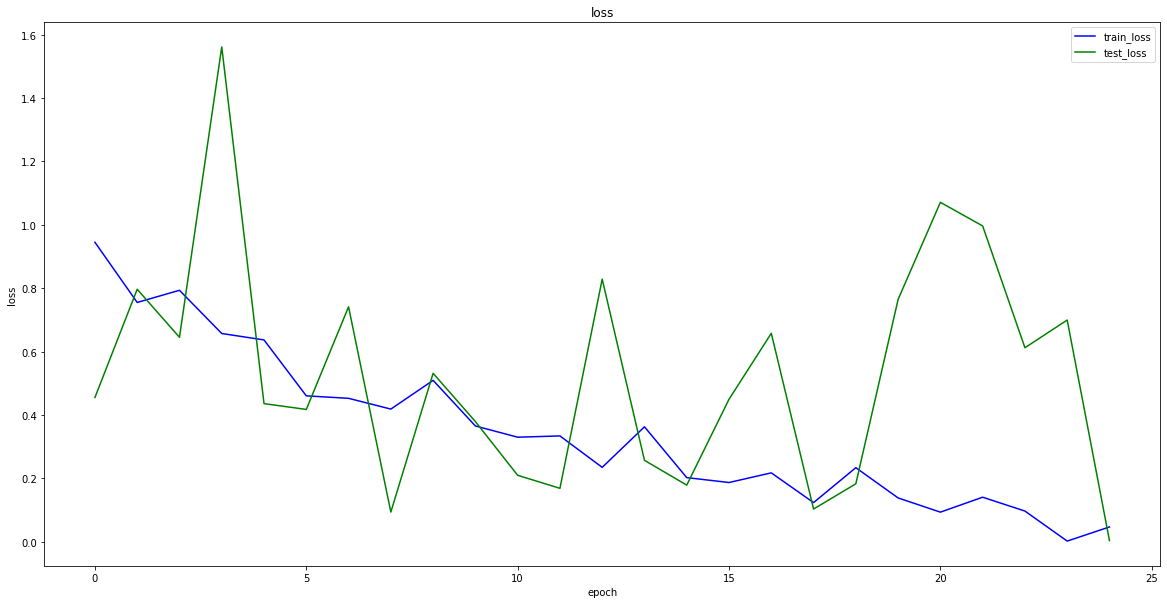

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_plot,'b')
plt.plot(test_loss_plot,'g')
plt.legend(('train_loss', 'test_loss'),loc='upper right')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  test_items = list(test_loader)[0]
  test_images = Variable(test_items[0]).cuda()
  test_labels = test_items[1]
  
  output = model(test_images)
  prob = F.softmax(output,dim=-1)
  idx = torch.argmax(prob,dim=-1)
  print(prob)
  print(idx)
  print(test_labels)
  acc = (test_labels == idx.cpu()).sum() / test_labels.shape[0]
  print('acc: ',acc.item()* 100)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[3.4440e-05, 9.9997e-01],
        [1.9289e-06, 1.0000e+00],
        [1.2342e-03, 9.9877e-01],
        [3.3329e-03, 9.9667e-01],
        [2.2525e-05, 9.9998e-01],
        [6.5834e-05, 9.9993e-01],
        [4.9141e-06, 1.0000e+00],
        [3.4788e-04, 9.9965e-01]], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1])
acc:  100.0
